In [53]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

import os

# **INTRODUCTION**

Before reading my work, I suggest you to have a look at tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html (Most of the following code was adopted from this source) to have a general idea of functions or steps in my work. Or you can skip this if you're familiar to the tutorial.  

In this paper, I assume that you already had an idea about the MNIST Data, so I won't introduce the MNIST Data again. 
Morever, what makes you want to read my work instead of reading others? First, let's look at some work from other people. 
  
1. https://medium.com/analytics-vidhya/hello-world-of-computer-vision-mnist-handwritten-digit-classification-a5c28f6276e1 is a good article of introduction to MNIST Data, but it doesn't use Pytorch.
2. https://nextjournal.com/gkoehler/pytorch-mnist is the next good source for exploring MNIST Data, but it uses advanced and extra code in testing and evaluating accuracy. I mean what if your model is required to test with the same code from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html (look at the code in 5. Test the network on the test data), so you can't write more code in testing section. 
3. https://medium.com/analytics-vidhya/training-mnist-handwritten-digit-data-using-pytorch-5513bf4614fb has a lot of syntax errors in code and it simply doesn't work at all

Therefore, I use Pytorch in my work and keep my code as simple as possible. Even though my code is simple, the model still get a fairly high accuracy ~92% (I stopped at 92%, but I think the model is still possible to improve). The model'size is less than 1MB. I followed the template from the tutorial (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html), so that everyone is able to follow my work easily.

## **Digit Recognition Using the MNIST Data**

### **1.Download and Transform the MNIST Data**
Firstly, we need to download the MNIST Data from the source and transform it.
We transform it because it make things a lit bit more interesting in traning and evaluating. 

We also create an array containing labels and set a batch's size to be 64.

In [43]:
classes = list(str(i) for i in range(10))
batch_size = 64

transformation_list = [transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))]
transform = transforms.Compose(transformation_list)

trainset = torchvision.datasets.MNIST(root='/data_mnist', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='/data_mnist', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

device = torch.device("gpd" if torch.cuda.is_available() else "cpu") #cuda

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1362: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1376: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data_mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data_mnist/MNIST/raw



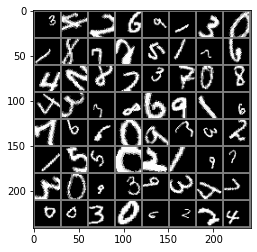

    3     4     2     6     9     1     3     0     1     8     7     2     5     1     7     6     4     2     8     2     3     7     0     8     4     3     3     8     6     9     1     6     7     6     6     0     9     3     3     2     1     5     5     0     2     1     9     7     3     0     9     3     9     3     4     7     0     0     3     0     6     2     2     4
<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [44]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
print(type(images))
print(images.shape)
print(labels.shape)

You can see that each patch will have 64 images = 64 numbers. Each image has size of 28x28 (not 32x32) and 1 dimension.

### **2.Defining the Model**


*   The skeleton of this section comes from the Pytorch's tutorial, but the main content or the heart of the model was studied and came from me.
*   I used 3 convolutional layers with 3 Max-Pooling Layers and 4 fully-connected layers in the model.
*   All calculations are based on this https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/ 
1. The first convolutional layer, nn.Conv2d(a, b, c) will take 3 numbers, the first number a is the original dimension of the image (the dimension is 1 in this case), b is the new dimension and c is a number we want to substract from to form a new size. In this case, I used (1, 28, 3) which means new dimension = 28, new size = 26x26 because 28 - 3 + 1 (since padding is set to 0 and stride is set to 1). Therefore, the new size is 28x26x26. The number of parameters is 28x((1x3x3)+1) = 280 (because the first convolutional layer expects 1 input channels and will convolve 28 filters each of size 1x3x3)

2. Then, the first down-sampling layer (the Max-pooling layer) uses max pooling with a 2x2 kernel and stride set to 2. This will drops the size from 28x26x26 to 28x13x13. We use Max-pooling layer because the convolutional layer might have pixels that have the same values (duplicate pixels) or contain unuseful information. We can use Max-pooling to drop unuseful pixels.

3. The second convolutional layers expects 28 input channels and will convolve 56 filters each of size 28x2x2. Therefore, the new size will be 56x(13-2+1)x12 == 56x12x12. The number of parameters is 56x((28x2x2)+1) = 6328.

4. We use a Max-pooling layer here. => the size is down to 56x6x6.

5. The third convolutional layers expects 56 input channels and will convolve 128 filters each of size 128x3x3. Therefore, the new size will be 128x4x4. The number of parameters is 128x((56x4x4)+1) = 114816.

6. We use a Max-pooling layer here. => the size is down to 128x2x2.

7. The output from the final max pooling layer needs to be flattened so that we can connect it to a fully connected layer. This is achieved using the torch.flatten(x, 1).

8. The fully-connected layer uses ReLU for activation and has 256 nodes, so the number of parameter is ((128x2x2)+1)x256 = 131328.

9. We connect the first fully-connected layer to the second fully-connected layer with 128 nodes and use Relu activation. The number of parameter is (256 + 1) x 128 = 32896 

10. The third fully-connected layer uses (128 + 1) x 32 = 4128 parameters.

11. The final fully-connected layer uses (32 + 1) x 10 = 330 parameters.

12. The total number of parameters is 280 + 6328 + 114816 + 131328 + 32896 + 4128 + 330 = 290106

13. We use log_softmax for the model

In [47]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 28, 3) # 28x(28-3+1)x26
        self.pool = nn.MaxPool2d(2, 2) # 28x13x13
        
        self.conv2 = nn.Conv2d(28,56,2) # 56x(13-2+1)x12
        self.pool = nn.MaxPool2d(2, 2) # 56x6x6
        
        self.conv3 = nn.Conv2d(56, 128, 3) # 128x(6-3+1)x4     
        self.pool = nn.MaxPool2d(2, 2) # 128x2x2
       
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
net = Net()
### Build a feed-forward network

### **3.Defining The Loss Function and The Optimizer**
Because we used log_softmax(), I will use NLLLoss() as a loss function and to optimize the model I will employ the popular Adam with a very low learning rate.


In [48]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.003) 

### **4.Training the Model**

In training, we will use 10 epochs because I think looping over 10 epochs is longer enough to get a high accuracy.

While traning, we will collect the training loss. If the training loss decrease over each epoch, that means we're on right track.

In [49]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(trainloader)))


Epoch 0 - Training loss: 1.2189225875047733
Epoch 1 - Training loss: 0.5544298173172642
Epoch 2 - Training loss: 0.44278202236079967
Epoch 3 - Training loss: 0.3947938451094668
Epoch 4 - Training loss: 0.36676113937359883
Epoch 5 - Training loss: 0.3516417455031419
Epoch 6 - Training loss: 0.33291913066178497
Epoch 7 - Training loss: 0.3208668279542979
Epoch 8 - Training loss: 0.3110969389306266
Epoch 9 - Training loss: 0.3040382800174992


### **5.Storing the Model**

In [51]:
message = 'Here you should store the model at "./mnist_net.pth" .'
print(message)

PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

Here you should store the model at "./mnist_net.pth" .


### **6. Evaluating the Trained Model**

In [54]:
assert 'Net' in globals().keys(), 'The Net class was not defined earlier. ' + \
                                 'Make sure you read and follow the instructions provided as Important Notes' + \
                                 '(especially, the "Model Class Naming" part).'

mnist_net_path = './mnist_net.pth'

assert os.path.exists(mnist_net_path), 'You have not stored the trained model properly. ' + \
                                      'Make sure you read and follow the instructions provided as Important Notes.'

assert os.path.getsize(mnist_net_path) < 1000000, 'The size of your trained model exceeds 1 MB.'

if 'net' in globals():
    del net
net = Net()
net.load_state_dict(torch.load(mnist_net_path))
net = net.eval()

# Disclaimer: Most of the following code was adopted from Pytorch's Documentation and Examples
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transformation_list = [transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))]

test_pre_tranformation = transforms.Compose(transformation_list)

mnist_root = '/data_mnist' 
testset = torchvision.datasets.MNIST(root=mnist_root, train=False,
                                     download=False, transform=test_pre_tranformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('----------')
print(f'Overall Testing Accuracy: {100. * sum(class_correct) / sum(class_total)} %%')

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1362: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1376: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


Accuracy of     0 : 95 %
Accuracy of     1 : 97 %
Accuracy of     2 : 90 %
Accuracy of     3 : 91 %
Accuracy of     4 : 92 %
Accuracy of     5 : 88 %
Accuracy of     6 : 91 %
Accuracy of     7 : 89 %
Accuracy of     8 : 84 %
Accuracy of     9 : 92 %
----------
Overall Testing Accuracy: 91.52 %%


## **What's next?**
1.   You can read this article https://towardsdatascience.com/going-beyond-99-mnist-handwritten-digits-recognition-cfff96337392 and try to improve the model.
2.   Create your own model for this Pytorch's CIFAR-10 https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


